# 数据挖掘作业-Apriori算法实现
> 作者：谭泽人
> 
> 班级：交叉研20
> 
> 学号：2020211335
> 
> 邮箱：tanzr20@mails.tsinghua.edu.cn

# Import Libraries
`numpy` and `pandas` are used to read csv data. `defaultdict` is a python dictionary that assigns default value to non-exist key, that is, it will not raise error when we put some key that does not exist in dictionary's key list. `chain` and `combinations` are used to generate proper subsets. `sys` and `OptionParser` deal with command line input. `datetime` is used to calculate running time.

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import sys
from optparse import OptionParser
from itertools import chain, combinations
from datetime import datetime
import matplotlib.pyplot as plt

# Have a Look at Our Data
Each row contains the number of items purchased and the list of items. Item list is useful in our following discussion while the number of items purchased is useless in our computation.

In [2]:
path = 'groceries.csv'
transactionData = pd.read_csv(path)
transactionData.head(5)

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,...,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Apriori Algorithm

In [3]:
def readDataFromFile(filename):
    '''
    parameter(s)::
        filename: the file name that is going to be read. 
    return::
        a generator contains all transactions
    '''
    with open(filename,'r') as file:
        for line in file:
            line = line.rstrip(',\n')
            record = frozenset(line.split(',')[1:])
            yield record

def getItemSetTransactionList(transactionGenerator):
    '''
    parameter(s)::
        transactionGenerator: a generator contains all transactions
    return::
        itemSet: the set of items exist in all transactions
        transactionList: a python list contains all transactions
    '''
    itemSet = set()
    transactionList = list()
    for record in transactionGenerator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        for item in transaction:
            itemSet.add(frozenset([item]))
            
    return itemSet, transactionList

def minSupFilter(itemSet,transactionList,minSup,freqDict):
    '''
    parameter(s)::
        itemSet: the set of items exist in all transactions
        transactionList: a python list contains all transactions
        minSup: the specified minimum support
        freqDict: a python dictionary consists of the frequency of some patterns
    return::
        localItemSet: a python dictionary contains patterns that satisfy the minimum support constraint.
    '''
    localItemSet = set()
    if itemSet == set():
        return localItemSet
    localFreqDict = defaultdict(int)
    for item in itemSet:
        for transaction in transactionList:
            if item.issubset(transaction):
                freqDict[item] += 1
                localFreqDict[item] += 1
    for item,count in localFreqDict.items():
        if count >= minSup:
            localItemSet.add(item)
    return localItemSet

# def generateLkSetWithPrune(LSet,length,transactionList,minSup,freqDict):
#     LkSet = set([i.union(j) for i in LSet for j in LSet if len(i.union(j)) == length])
#     return minSupFilter(LkSet,transactionList,minSup,freqDict)

def generateLkSet(LSet,length):
    '''
    parameter(s)::
        LSet: patterns that has length of length-1
        length: the length of target patterns
    return::
        the set of patterns that have length length
    '''
    return set([i.union(j) for i in LSet for j in LSet if len(i.union(j))==length])

def properSubset(itemSet):
    '''
    parameter(s)::
        itemSet: a set of items
    return::
        all proper subsets of itemSet
    '''
    return chain(*[combinations(itemSet, i + 1) for i, a in enumerate(itemSet) if i<len(itemSet)-1])

def Apriori(transactionGenerator, minSup, minConf):
    '''
    parameter(s)::
        transactionGenerator: a generator contains all transaction
        minSup: minimum support
        minConf: minimum confidence
    return::
        LSetDict: a dictionary consists of patterns of all length that satisfy the minimum support constraint
        freqPattern: a python list contains all frequent pattern
        associationRule: a python list contains all association rule satisfy minimum support and minimum confidence constraints
    '''
    itemSet, transactionList = getItemSetTransactionList(transactionGenerator)
    freqDict = defaultdict(int)
    LOneCandidate = minSupFilter(itemSet,transactionList,minSup,freqDict)
    k = 2
    LSetDict = dict()
    currentLSet = LOneCandidate
    while (currentLSet != set()):
        LSetDict[k-1] = currentLSet
        tempSet = currentLSet
        currentLSet = generateLkSet(tempSet,k)
        currentCSet = minSupFilter(currentLSet,transactionList,minSup,freqDict)
        currentLSet = currentCSet  
        k += 1

    freqPattern = list()
    for key, lset in LSetDict.items():
        freqPattern.extend([(set(item),freqDict[item]) for item in lset])
    associationRule = list()
    for key, lset in list(LSetDict.items())[1:]:
        for lseq in lset:
            properSubsets = [frozenset(x) for x in properSubset(lseq)]
            for item in properSubsets:
                if (len(lseq.difference(item))>0):
                    conf = freqDict[lseq]/freqDict[item]
                    if conf >= minConf:
                        associationRule.append([set(item),set(lseq.difference(item)),conf])
    return LSetDict, freqPattern,associationRule  

# Run Apriori
I use the groceries.csv dataset. `minSup` and `minConfidence` are set to be 100 and 0.5, respectively.

In [10]:
path = 'groceries.csv'
file = readDataFromFile(path)
minSup = 100
minConf = 0.5
t1 = datetime.now()
LSetDict, freqPattern, associationRule = Apriori(file,minSup,minConf)
t2 = datetime.now()
print('Total running time of Apriori with minSup %d, minConf %.2f is: %.4f s' %(minSup,minConf,(t2-t1).seconds))

Total running time of Apriori with minSup 100, minConf 0.50 is: 6.0000 s


# Save Results
I save `freqPattern` and `associationRule` to csv files.

In [11]:
freqPatternDF = pd.DataFrame(freqPattern)
freqPatternDF.columns = ['pattern','frequency']
freqPatternDF.tail(5)

,pattern,frequency
321,"{bottled water, whole milk, other vegetables}",106
322,"{other vegetables, citrus fruit, whole milk}",128
323,"{yogurt, rolls/buns, other vegetables}",113
324,"{whipped/sour cream, whole milk, other vegetab...",144
325,"{tropical fruit, whole milk, yogurt}",149


In [17]:
freqPatternDF.iloc[309:,:].sort_values(by='frequency',ascending = False).head(5)

,pattern,frequency
317,"{root vegetables, whole milk, other vegetables}",228
309,"{yogurt, whole milk, other vegetables}",219
320,"{yogurt, rolls/buns, whole milk}",153
325,"{tropical fruit, whole milk, yogurt}",149
324,"{whipped/sour cream, whole milk, other vegetab...",144


In [6]:
freqPatternDF.to_csv('frequentPattern.csv')

In [7]:
associationRuleDF = pd.DataFrame(associationRule)
associationRuleDF.columns = ['X','Y','confidence']
associationRuleDF.head(5)

,X,Y,confidence
0,"{citrus fruit, root vegetables}",{other vegetables},0.586207
1,"{yogurt, root vegetables}",{other vegetables},0.500000
2,"{other vegetables, domestic eggs}",{whole milk},0.552511
3,"{rolls/buns, root vegetables}",{whole milk},0.523013
4,"{yogurt, root vegetables}",{whole milk},0.562992


In [20]:
associationRuleDF.sort_values(by='confidence')

,X,Y,confidence
1,"{yogurt, root vegetables}",{other vegetables},0.500000
11,"{rolls/buns, root vegetables}",{other vegetables},0.502092
12,"{whipped/sour cream, other vegetables}",{whole milk},0.507042
5,"{other vegetables, yogurt}",{whole milk},0.512881
13,"{tropical fruit, yogurt}",{whole milk},0.517361
8,"{pip fruit, other vegetables}",{whole milk},0.517510
3,"{rolls/buns, root vegetables}",{whole milk},0.523013
9,"{whipped/sour cream, yogurt}",{whole milk},0.524510
2,"{other vegetables, domestic eggs}",{whole milk},0.552511
4,"{yogurt, root vegetables}",{whole milk},0.562992


In [8]:
associationRuleDF.to_csv('associationRule.csv')

# Run Apriori With Different `minSup` and `minConf`
## Run With Different `minSup`

In [23]:
epochs = 25
minConf = 0.3
numFreqPatterns = list()
numAssociationRules = list()
runTime = list()
for epoch in range(epochs):
    minSup = 10*(epoch+1)
    path = 'groceries.csv'
    file = readDataFromFile(path)
    t1 = datetime.now()
    LSetDict, freqPattern, associationRule = Apriori(file,minSup,minConf)
    numFreqPatterns.append(len(freqPattern))
    numAssociationRules.append(len(associationRule))
    t2 = datetime.now()
    runTime.append((t2-t1).seconds)
#         print('Total running time of Apriori with minSup %d, minConf %.2f is: %.4f s' %(minSup,minConf,(t2-t1).seconds))
#         print('Number of Frequent Patterns: %d' % len(freqPattern))
#         print('Number of Association Rules: %d' % len(associationRule))

KeyboardInterrupt: 

In [28]:
RunTimes

[[298,
  99,
  47,
  28,
  20,
  14,
  11,
  9,
  7,
  6,
  5,
  4,
  4,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  324,
  115,
  50,
  29,
  22,
  20,
  13,
  10,
  8,
  6,
  5,
  4,
  4,
  4,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  3,
  3,
  2,
  2,
  291,
  95,
  43,
  27,
  24,
  14,
  11,
  10,
  7,
  5,
  4,
  4,
  4,
  3,
  3,
  3,
  4,
  2,
  3,
  2,
  1,
  1,
  1,
  1,
  1,
  305,
  102,
  48,
  27,
  23,
  17,
  13,
  9,
  7,
  5,
  4,
  4,
  3,
  4,
  3,
  3,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  297,
  98,
  45,
  33,
  21,
  14,
  13,
  15,
  10,
  8],
 [298,
  99,
  47,
  28,
  20,
  14,
  11,
  9,
  7,
  6,
  5,
  4,
  4,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  324,
  115,
  50,
  29,
  22,
  20,
  13,
  10,
  8,
  6,
  5,
  4,
  4,
  4,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  3,
  3,
  2,
  2,
  291,
  95,
  43,
  27,
  24,
  14,
  11,
  10,
  7,
  5,
  4,
  4,
  4,
  3,
  3,
  3,
  4,
  2,
  3,
  2,
  1,
  1,
  1,
  1,
  1,
 

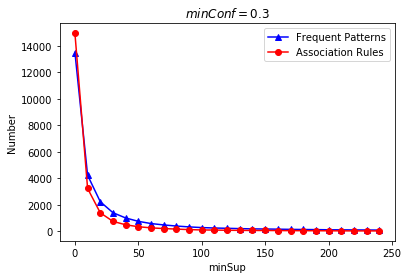

In [16]:
plt.plot(range(25),numFreqPatterns[:25],'-b^')
plt.plot(range(25),numAssociationRules[:25],'-ro')
plt.xticks(range(0,30,5),np.array([10*i for i in range(0,30,5)],dtype = np.int16))
plt.xlabel('minSup')
plt.ylabel('Number')
plt.title('$minConf = 0.3$')
plt.legend(['Frequent Patterns','Association Rules'])
plt.savefig('minsup.pdf')

In [42]:
temp = [list(RunTimes[1][25*x:25*(x+1)]) for x in range(4)]
RunTimeMax = np.max(temp,axis = 0)
RunTimeMin = np.min(temp,axis = 0)
RunTimeMean = np.mean(temp,axis = 0)

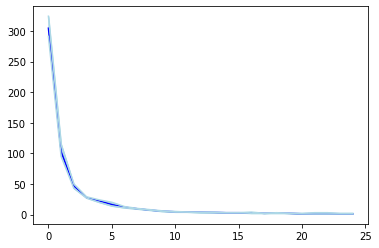

In [47]:
fig,ax = plt.subplots()
ax.plot(RunTimeMean,'blue')
ax.plot(RunTimeMax,'lightblue')
ax.plot(RunTimeMin,'lightblue')
ax.fill_between(range(25),RunTimeMax,RunTimeMin,color = 'lightblue')

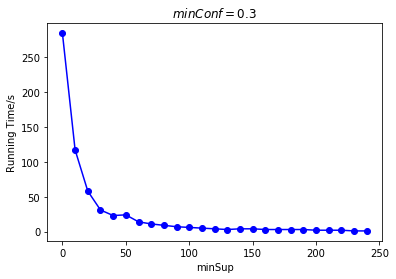

In [22]:
plt.plot(range(25),runTime[:25],'-bo')
plt.xticks(range(0,30,5),np.array([10*i for i in range(0,30,5)],dtype = np.int16))
plt.xlabel('minSup')
plt.ylabel('Running Time/s')
plt.title('$minConf = 0.3$')
plt.savefig('timesup.pdf')

## Run With Different `minConf`

In [28]:
epochs = 10
minSup = 100
numFreqPatterns = list()
numAssociationRules = list()
runTime = list()
for epoch in range(epochs):
    minConf = 0.1*(epoch+1)
    path = 'groceries.csv'
    file = readDataFromFile(path)
    t1 = datetime.now()
    LSetDict, freqPattern, associationRule = Apriori(file,minSup,minConf)
    numFreqPatterns.append(len(freqPattern))
    numAssociationRules.append(len(associationRule))
    t2 = datetime.now()
    runTime.append((t2-t1).seconds)
    print('Total running time of Apriori with minSup %d, minConf %.2f is: %.4f s' %(minSup,minConf,(t2-t1).seconds))
    print('Number of Frequent Patterns: %d' % len(freqPattern))
    print('Number of Association Rules: %d' % len(associationRule))

Total running time of Apriori with minSup 100, minConf 0.10 is: 9.0000 s
Number of Frequent Patterns: 326
Number of Association Rules: 448
Total running time of Apriori with minSup 100, minConf 0.20 is: 9.0000 s
Number of Frequent Patterns: 326
Number of Association Rules: 230
Total running time of Apriori with minSup 100, minConf 0.30 is: 10.0000 s
Number of Frequent Patterns: 326
Number of Association Rules: 122
Total running time of Apriori with minSup 100, minConf 0.40 is: 10.0000 s
Number of Frequent Patterns: 326
Number of Association Rules: 60
Total running time of Apriori with minSup 100, minConf 0.50 is: 10.0000 s
Number of Frequent Patterns: 326
Number of Association Rules: 14
Total running time of Apriori with minSup 100, minConf 0.60 is: 10.0000 s
Number of Frequent Patterns: 326
Number of Association Rules: 0
Total running time of Apriori with minSup 100, minConf 0.70 is: 11.0000 s
Number of Frequent Patterns: 326
Number of Association Rules: 0
Total running time of Aprior

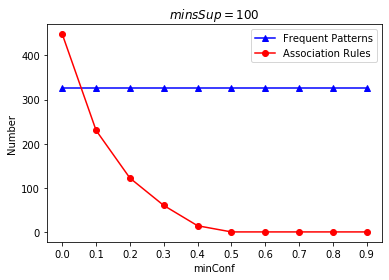

In [29]:
plt.plot(range(epochs),numFreqPatterns,'-b^')
plt.plot(range(epochs),numAssociationRules,'-ro')
plt.xticks(range(10),np.array([0.1*i for i in range(10)],dtype = np.float16))
plt.xlabel('minConf')
plt.ylabel('Number')
plt.title('$minsSup = 100$')
plt.legend(['Frequent Patterns','Association Rules'])
plt.savefig('minconf.pdf')

Text(0, 0.5, 'Running Time/s')

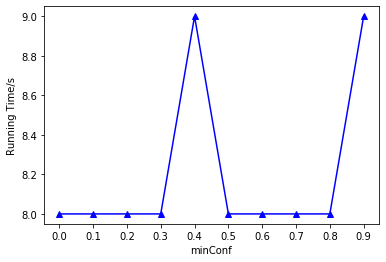

In [14]:
plt.plot(range(epochs),runTime,'-b^')
plt.xticks(range(10),np.array([0.1*i for i in range(10)],dtype = np.float16))
plt.xlabel('minConf')
plt.ylabel('Running Time/s')